# Predictions on TMDB Datasets

This is a machine learning project that will consist on predicting different things about the TMDB Datasets. The objective of this notebook is to use machine learning.

### Predicting revenue based on budget, runtime and popularity

### Classifying films on genre based on revenue, popularity

## Plan

This is the plan that we are going to follow.

1. read csv file
2. remove columns that have little correlation or we don't need.
3. find if there are null values, dealing either by filling them it using media, average or in worst case dropping them.

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tmdb = pd.read_csv('tmdb_5000_movies.csv')



## Finding basic information about dataset

We will find the basic information about the dataset to deal with null values, duplicate values.

In [302]:
# to observe the data
tmdb.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [303]:
# finding the info for every row
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [304]:
##  Find descriptive stadistics
tmdb.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


## Cleaning the dataset

In [305]:

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, sd):
    col_names = df.columns.values
    df_col_types = dict(df.dtypes)

    for name, t in df_col_types.items():
        if t != np.object:
            name = str(name)
            drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
            df.drop(drop_rows, axis=0, inplace=True)
    
# Convert all missing values in the specified column to the default filling with mean of column
def remove_missing(df, nullRatios, drop_col_ratio):
    # find mean of column skipping na
    meanv = df.mean(axis=1, skipna=True)
    col_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object']
    df_col_types = dict(df.dtypes)
    #percentage to fill or drop, if bigger the column is dropped
    minPercent = drop_col_ratio
    
    #col_type_num = df.columns.select_dtypes(numerics)
    #col_type_obj = df.columns.select_dtypes(obj_types)
    
    for k, v in nullRatios.items():

        print(k)
    
        if v > minPercent:
            df.drop(str(k), 1, inplace=True)
            #print(df.columns.values)       
        elif df_col_types[str(k)] == np.object:
            df.dropna(how='any', axis=0, inplace=True)
        else:
            
            df.fillna(value={k: meanv}, axis=0, inplace=True)
    
    #df[name] = df[name].fillna(default_value)
    
# find the ratio of nulls compared to total rows.
def find_missing_ratio(data):
    
    nullRatios = {}
    
    for val in list(data.columns.values):
        nullValuesCol = data[val].isnull().sum()
        totalCol = len(data[val])

        ratio = (nullValuesCol / totalCol) * 100
    
        if ratio > 0:
            nullRatios[val] = ratio

    # print values 
    for k, v in nullRatios.items():
        print('Column {key} has a ratio of {value}'.format(key = k, value = v))
        print(k)

    return nullRatios
        

In [306]:
tmdb.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [307]:
#save columns we do not need before removing
homepage = tmdb['homepage']
status = tmdb['status']
overview = tmdb['overview']
release_date = tmdb['release_date']
tag_line = tmdb['tagline']
#removing columns we don't new
tmdb.drop(['homepage', 'status', 'overview', 'release_date', 'tagline'], axis=1, inplace=True)

In [308]:
# get numeric and columns only

ratio_null = find_missing_ratio(tmdb)
remove_missing(tmdb, ratio_null, 20)
remove_outliers(tmdb, 2)

Column runtime has a ratio of 0.041640641265875494
runtime
runtime


In [309]:
#checking how many values are the
tmdb.isnull().sum()


budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
popularity              0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
spoken_languages        0
title                   0
vote_average            0
vote_count              0
dtype: int64

## Finding and plotting correlation between columns

We will use a heatmap to make the correlation matrix  of the columns to find if there is relationships between columns. 

Also we will use the corr() function to visualise how the data is distributed. 

<AxesSubplot:>

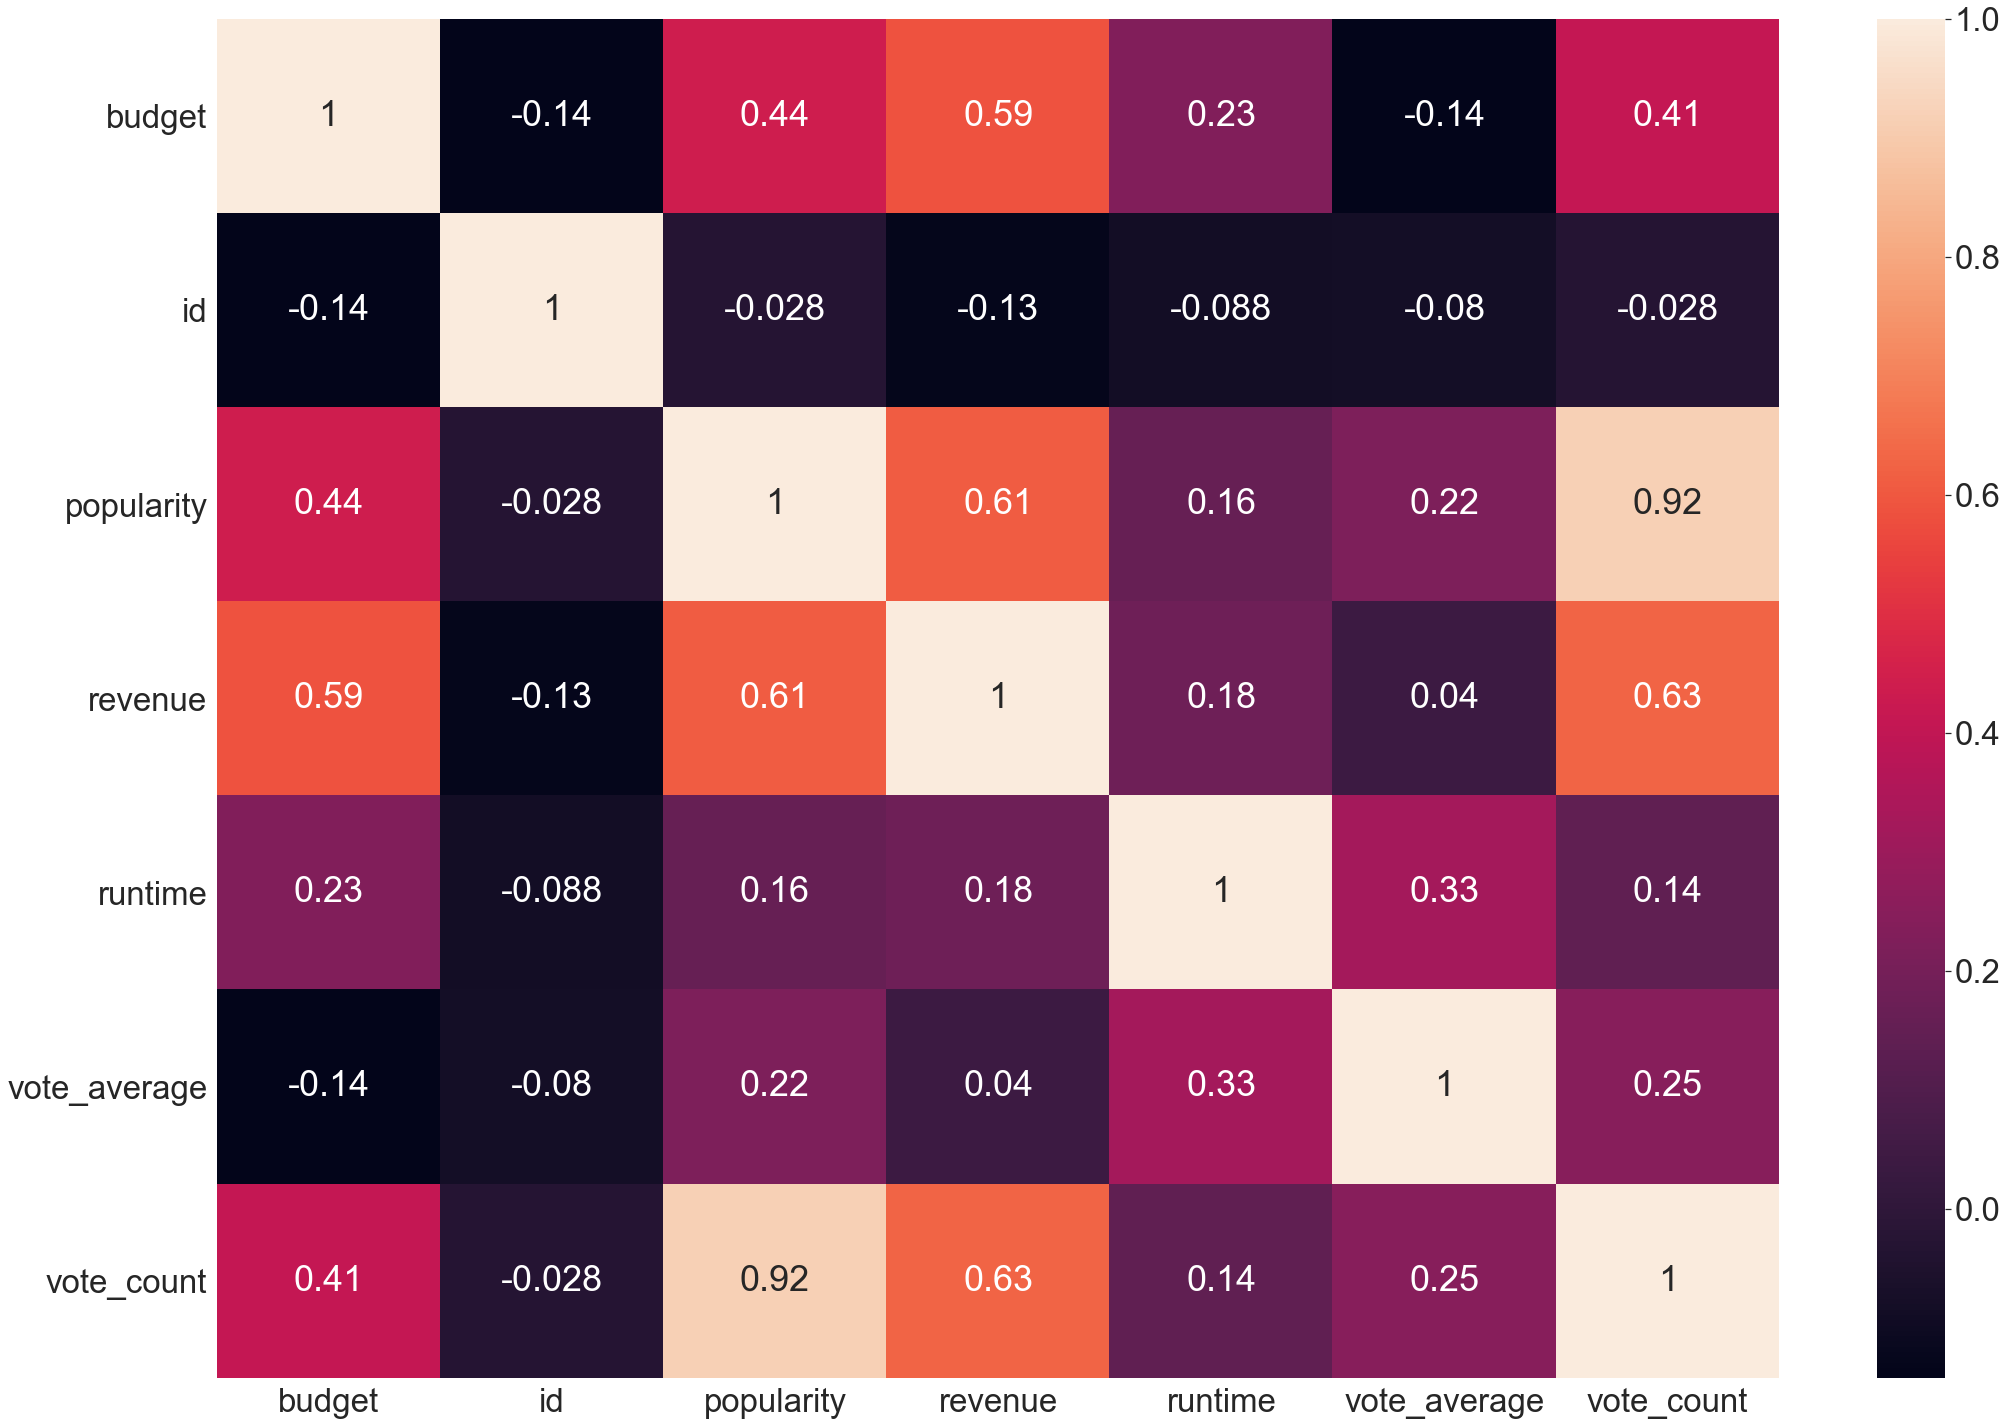

In [310]:
##  find correlations between columns using a correlation matrix
sns.set(font_scale=3)
plt.figure(figsize=(35, 25))
sns.heatmap(tmdb.corr(), annot=True)

array([[<AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'popularity'}>],
       [<AxesSubplot:title={'center':'revenue'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'vote_average'}>],
       [<AxesSubplot:title={'center':'vote_count'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

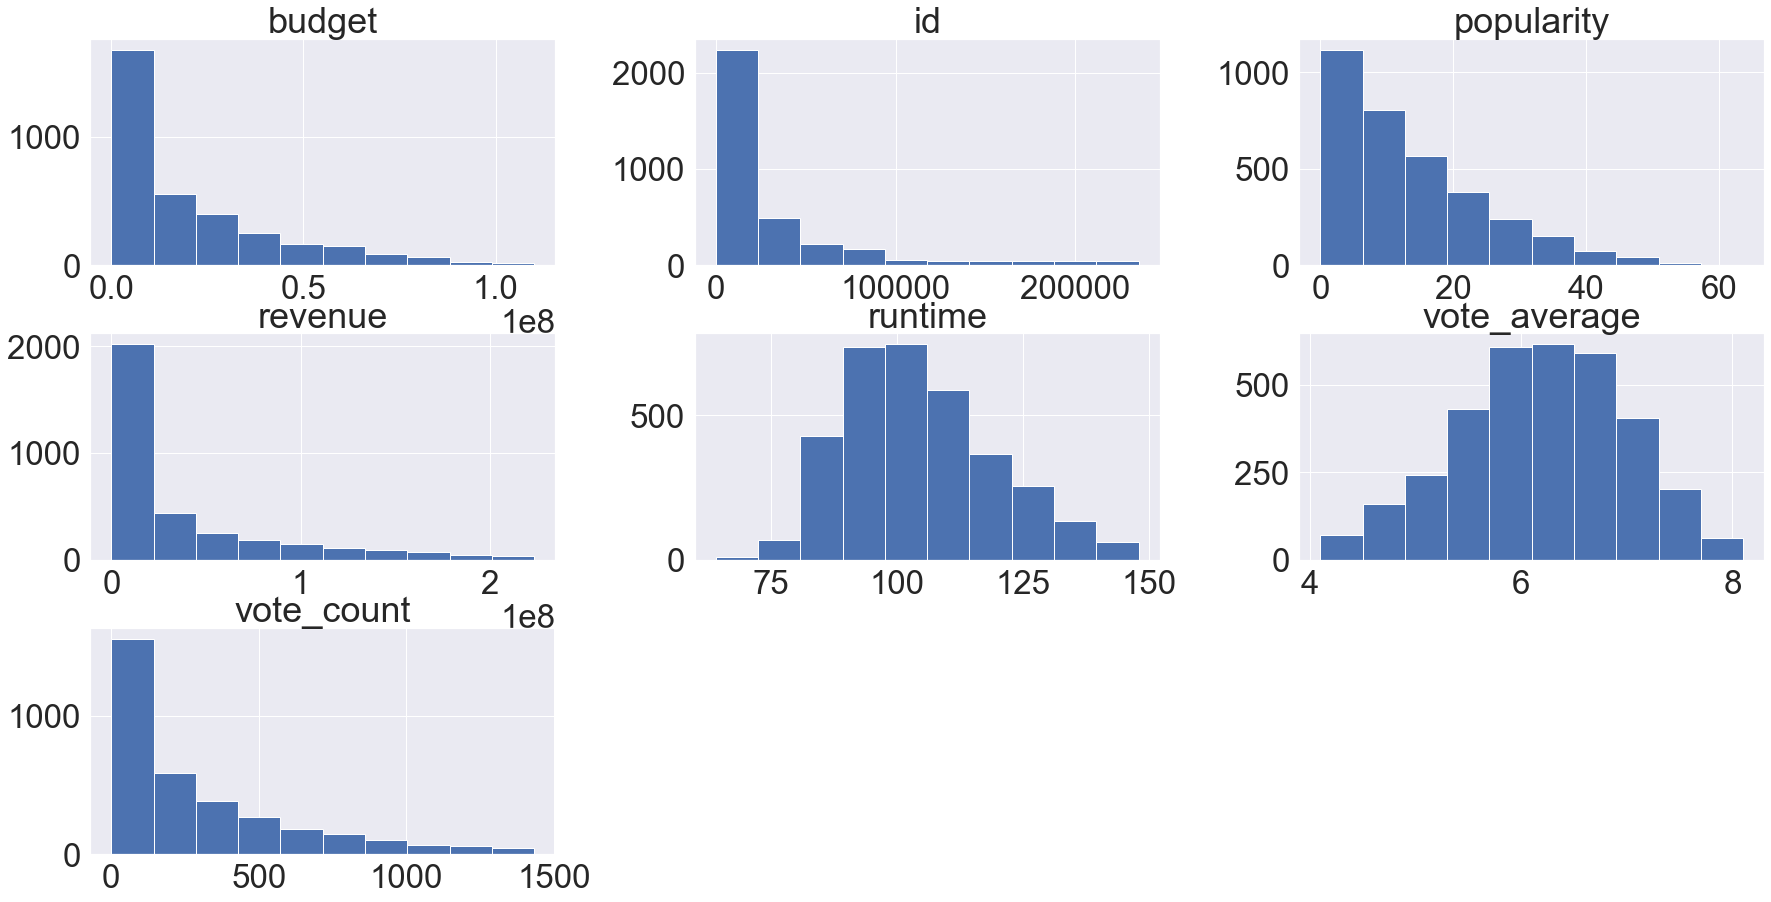

In [311]:
#Show distributions of every column

tmdb.hist(bins=10, figsize=(30, 15))

<Figure size 2160x2160 with 0 Axes>

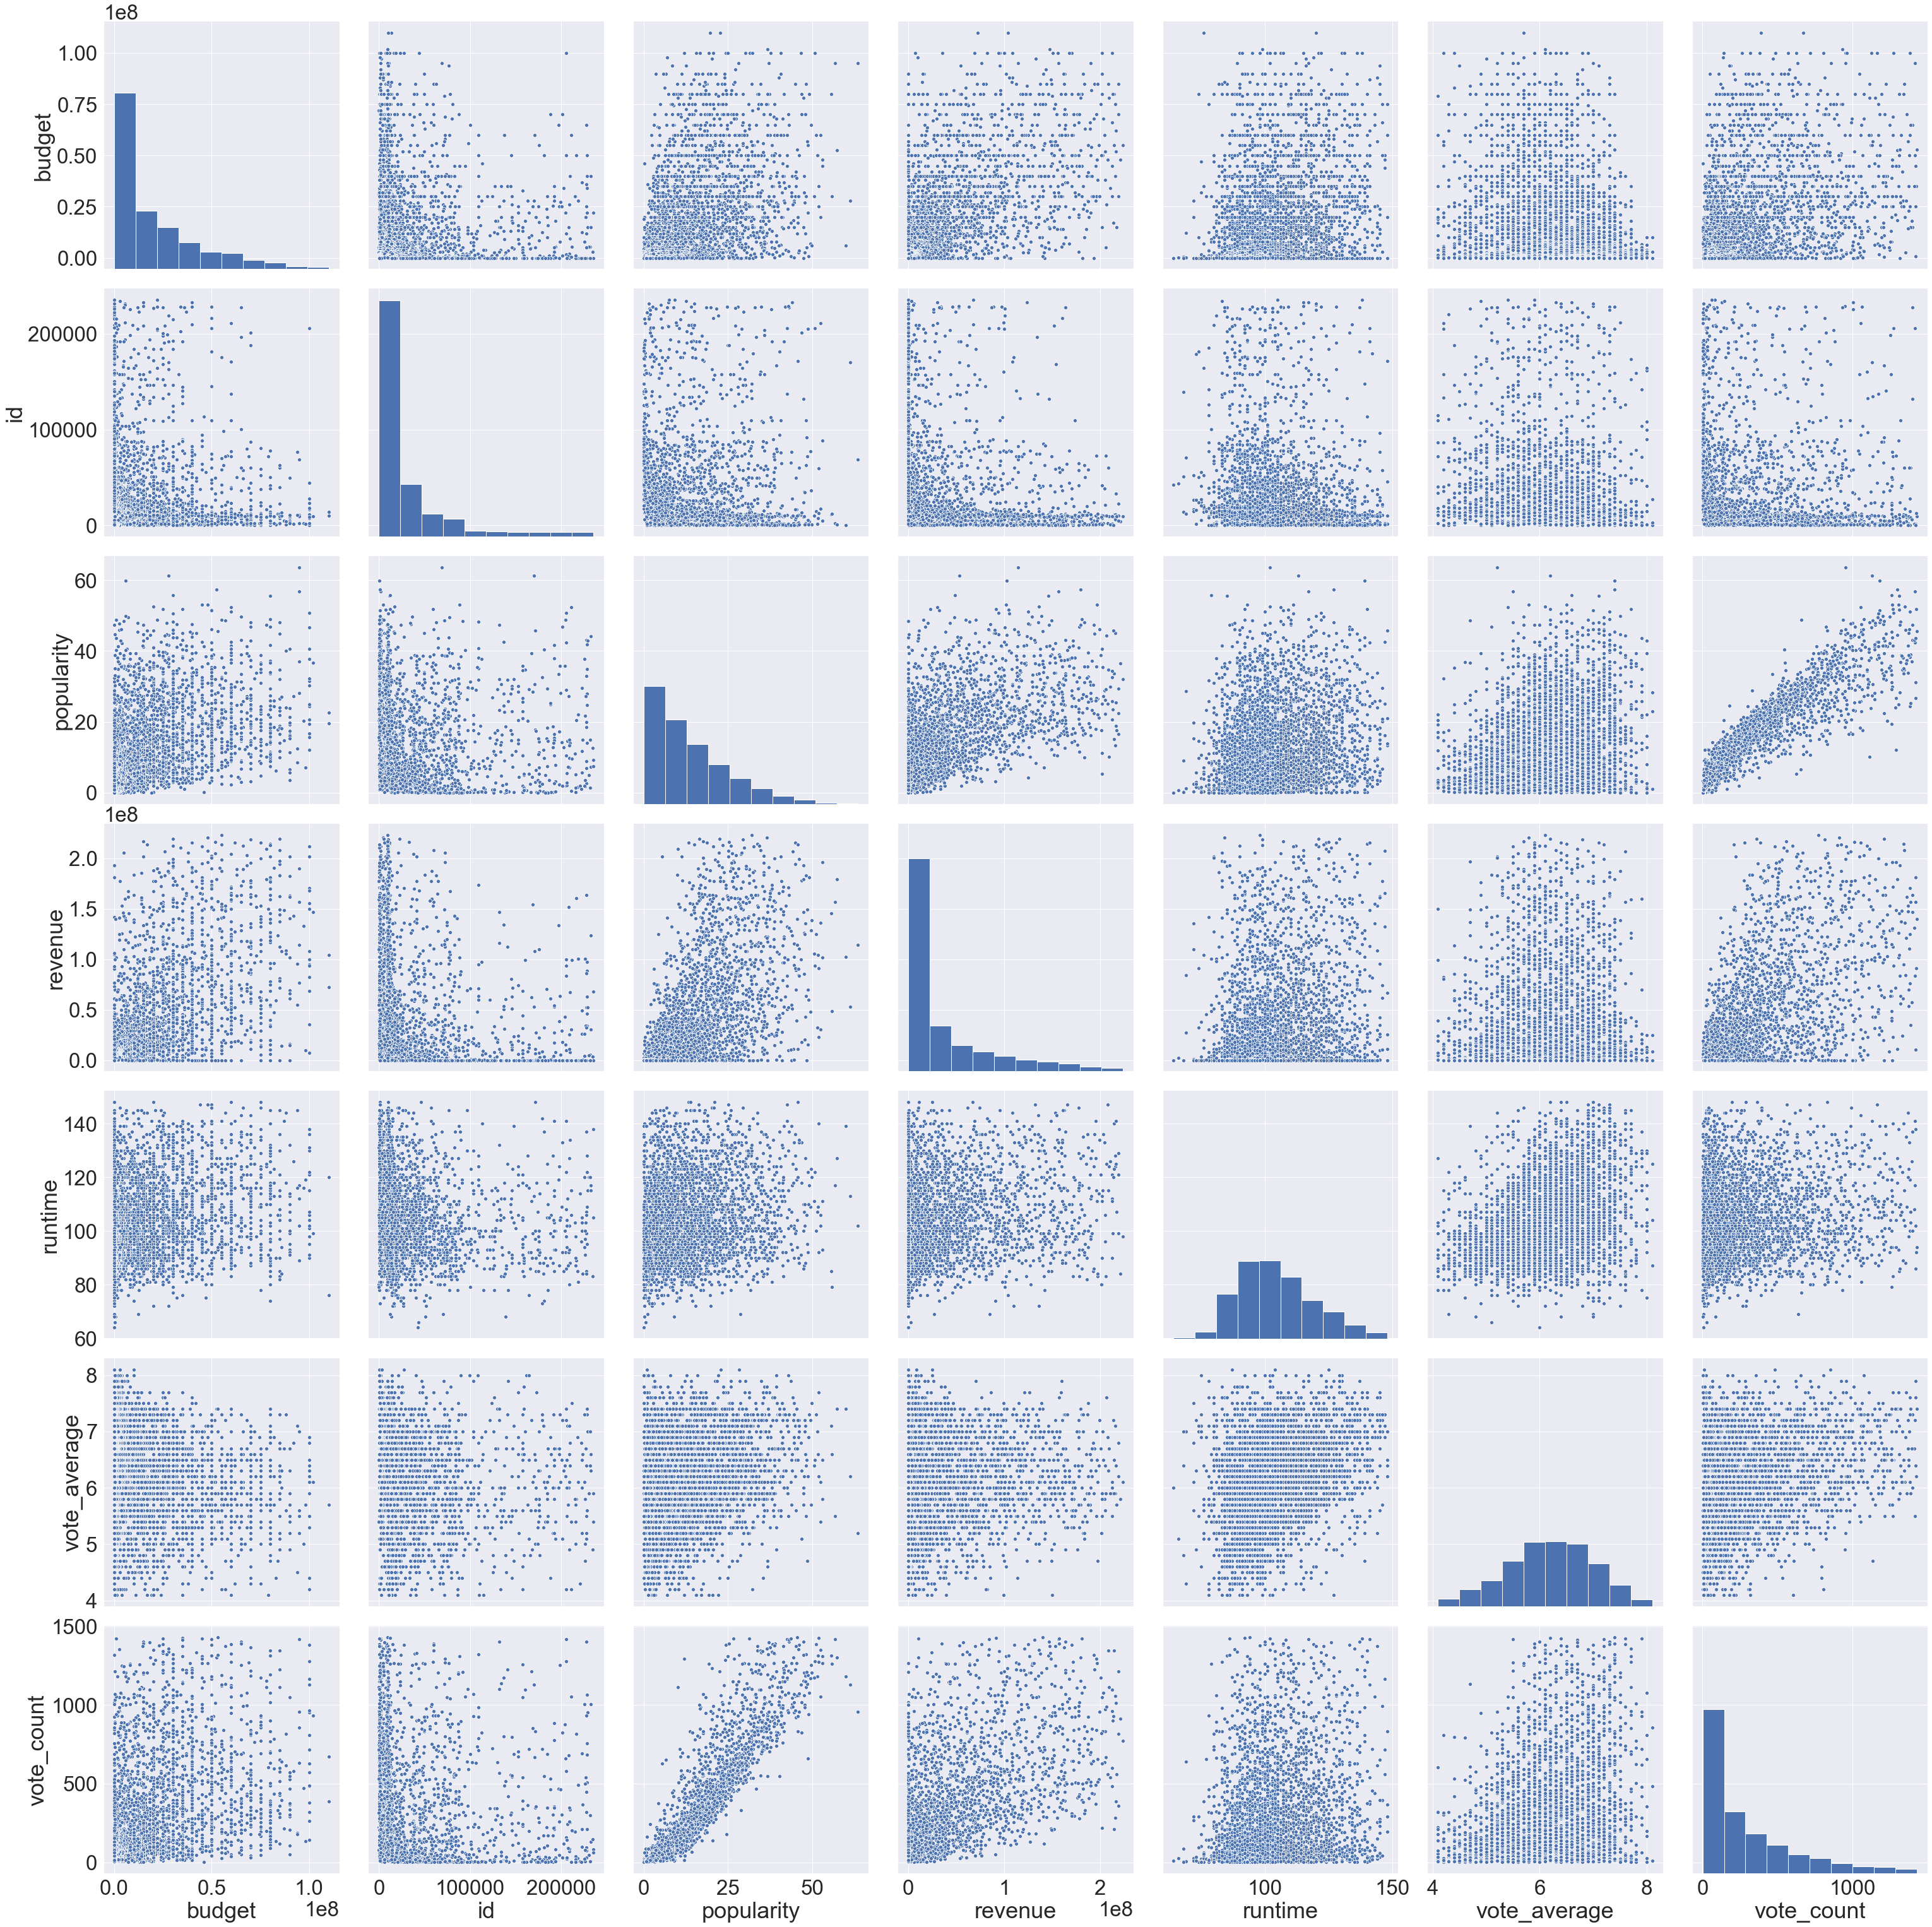

In [312]:
# show correlations to see how the data is distributed to apply different models.
plt.figure(figsize=(30, 30))
sns.pairplot(tmdb, height=6, diag_kind='hist')
plt.show()

## Findings

### Budget:

- Budget and runtime is normally distributed, therefore as the runtime ranges around 100, then the budget is great. 
- Budget and popularity follow a linear relationship, therefore Linear regression could be used to predict price. Larger budgets then to produce more popular films.

### Revenue

- Revenue and runtime is normally distributed, therefore as the runtime ranges around 100, then the budget is great. 
- Revenue and popularity follow a linear relationship, therefore Linear regression could be used to predict price. Popular fims tend to generate more revenue.
  
#### Budget and revenue have some linear correlation, although not as much as popularity. 